In [1]:
import torch
from torch.autograd import Variable
from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns


np.random.seed(42)



In [2]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
epochs = 10000

In [4]:
class SimpleModel(torch.nn.Module):
    def __init__(self,p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.criterion = torch.nn.MSELoss()

        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 10),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(10,1)
        )
        
        self.optimizer = torch.optim.Adam(
            self.parameters(),
            weight_decay=self.decay) 
        
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)
    
    def ensemble_uncertainity_estimate(self,X, iters, l2=0.005, range_fn=trange, raw_var=False):
        outputs = np.hstack([self(X[:, np.newaxis]).data.numpy() for i in range_fn(iters)])
        y_mean = outputs.mean(axis=1)
        y_variance = outputs.var(axis=1)
        if not raw_var:
            tau = l2 * (1-self.dropout_p) / (2*N*self.decay)
            y_variance += (1/tau)
        y_std = np.sqrt(y_variance) #+ (1/tau)
        return y_mean, y_std

    
    def uncertainty_function(self,X, iters, l2, range_fn=trange,raw_var=False):
        return self.ensemble_uncertainity_estimate(X=X, iters=iters, l2=l2, range_fn=trange,raw_var=raw_var)
    
    
    
    def fit_ensemble(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
                        
            losslist.append(self.fit_model(model, optimizer, X_abs,y_abs))
    
    
    def fit_model(self, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = self(X_obs[:, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss

In [5]:
N = 100


In [6]:


def generate_data(datalen=100,noise_level=0.2) -> np.array:
    """returns numpy arrays X and y that can be used as basis for regression problem"""

    #X = np.arange(0, self.datalen)
    X = np.linspace(0,300,datalen)

    freq1 = 0.2
    freq2 = 0.15

    freq1 = 0.1
    freq2 = 0.0375
    noise = np.random.randn(datalen) * noise_level
    
    def generate_y(X_):
        """nonlinear case"""
        y1 = np.sin(X_ * freq1) 
        y2 = np.sin(X_ * freq2) 
        return y1 + y2
    
    def generate_y_linear(X_):
        """linear case"""
        return X_/datalen
    
    y = generate_y(X) + noise
    

    
    padding = datalen/2
    
    X_long = np.insert(X,0,np.min(X)-padding)
    
    X_long = np.append(X_long,np.max(X)+padding)
    y_long = generate_y(X_long)
    
    X = (X - np.min(X_long)) / (np.max(X_long) - np.min(X_long))
    X_long = (X_long - np.min(X_long)) / (np.max(X_long) - np.min(X_long))

    return np.expand_dims(X.astype(np.float32),1), np.expand_dims(y.astype(np.float32),1), X_long, y_long

In [7]:
#[np.random.randn() for x in range(100)]

In [8]:
X,y,X_long,y_long = generate_data(N,0.3)

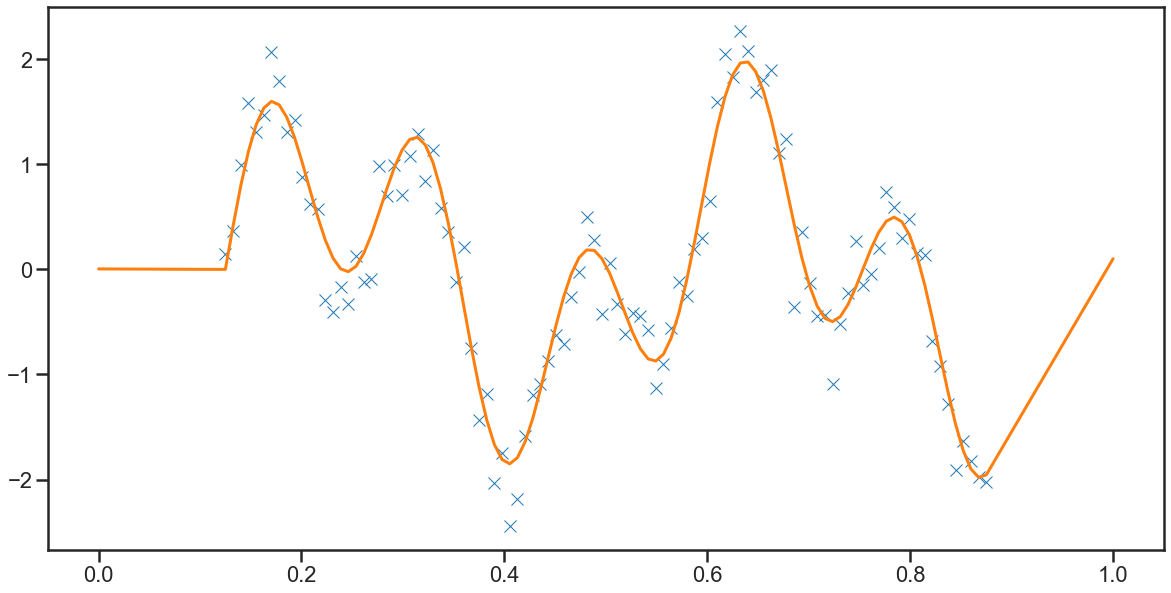

In [9]:
plt.plot(X,y,'x')
plt.plot(X_long,y_long)

In [10]:
model = SimpleModel()

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2127.60it/s]


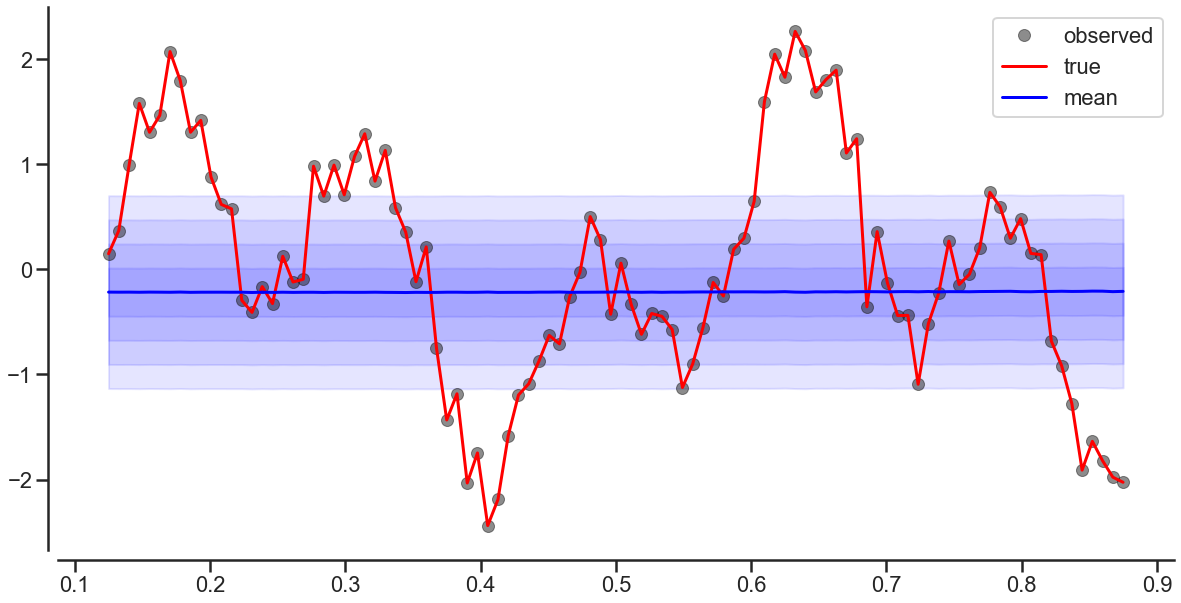

In [11]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X, iters, l2=l2)
    
ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X, y, ls="-", color="r", label="true")
ax.plot(X, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
ax.legend()
sns.despine(offset=10)


In [12]:
for i in trange(epochs):

    model.fit_model(X,y)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 686.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1723.95it/s]


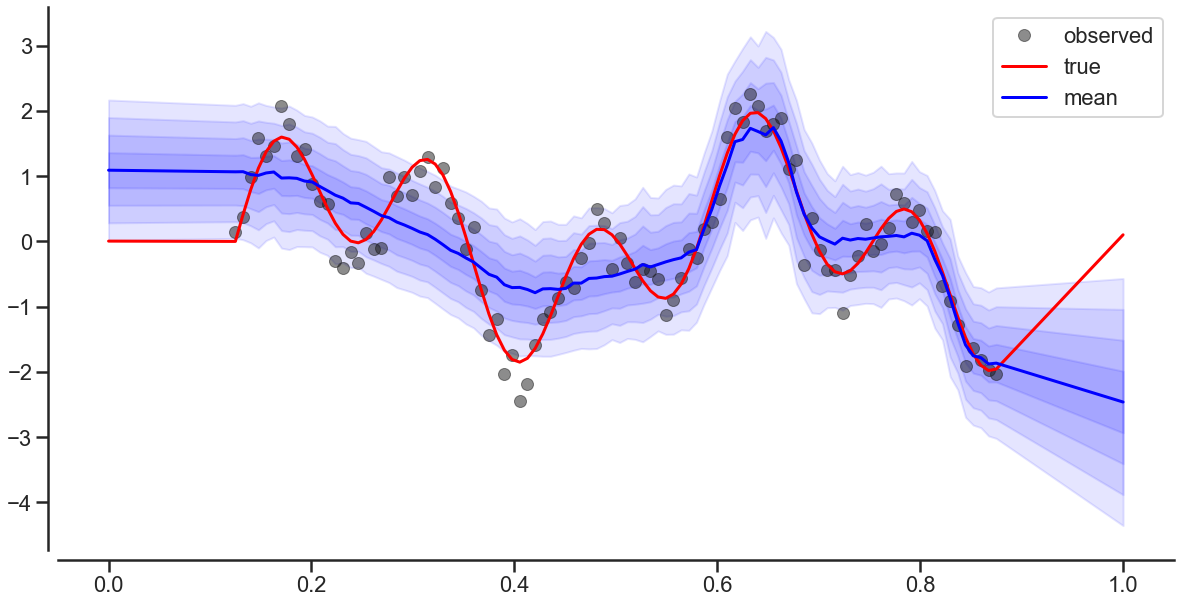

In [13]:

iters = 100
l2 = 1
n_std = 4


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X_long, iters, l2=l2)
y_mean_raw, y_std_raw = model.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")

for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
    
    

ax.legend()
sns.despine(offset=10)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2436.66it/s]


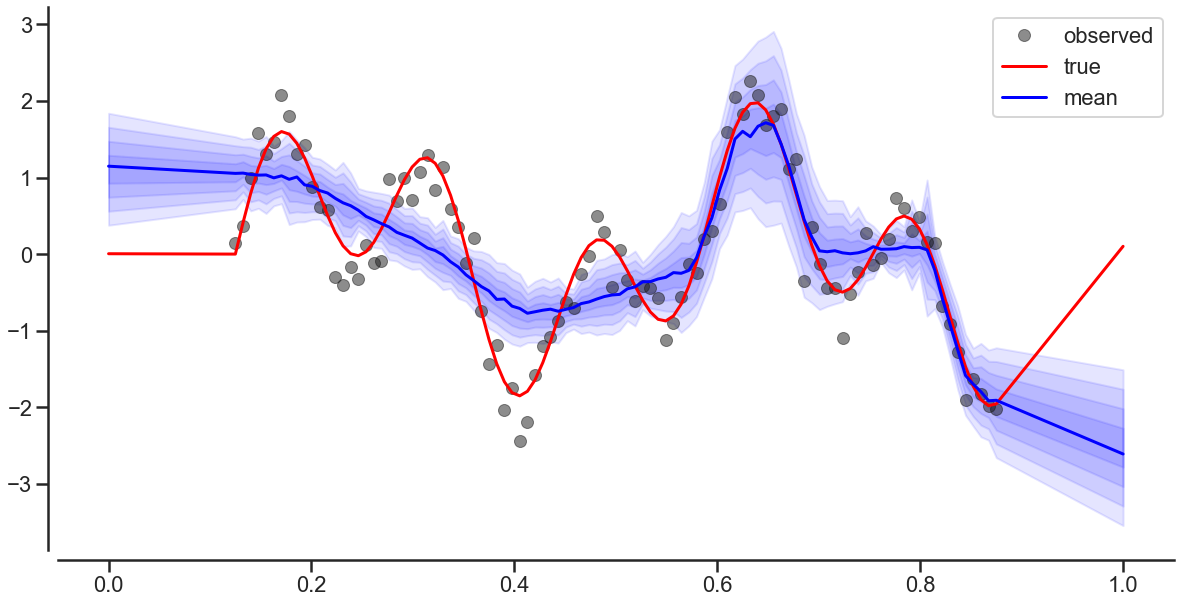

In [14]:


fig, ax = plt.subplots(1,1)
y_mean, y_std = model.uncertainty_function(X_long, iters, l2=l2)
y_mean_raw, y_std_raw = model.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean_raw.squeeze() - y_std_raw.squeeze() * ((i+1)/2),
        y_mean_raw.squeeze() + y_std_raw.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

# Ensembles


In [15]:
 
    
class VanillaEnsemble(object):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None):
        #super(VanillaEnsemble,self).__init__(X_obs,y_obs,X_true,y_true,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None)
        self.models = [SimpleModel(p,decay,non_linearity) for model in range(n_models)]
        self.optimizers = [torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay) for model in self.models]
        self.criterion = torch.nn.MSELoss()
        self.dropout_p = p
        self.decay = decay
    

    def ensemble_uncertainity_estimate(self,X, iters, l2=0.005, range_fn=trange):
        outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for model in self.models])
        y_mean = outputs.mean(axis=1)
        y_variance = outputs.var(axis=1)
        tau = l2 * (1-self.dropout_p) / (2*N*self.decay)
        y_variance += (1/tau)
        y_std = np.sqrt(y_variance)# + (1/tau)
        return y_mean, y_std
    
    
    def uncertainty_function(self,X, iters, l2, range_fn=trange):
        return self.ensemble_uncertainity_estimate(X=X, iters=iters, l2=l2, range_fn=trange)
    
    def fit_ensemble_member(self, model, optimizer, X_obs,y_obs):
        y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
        y_pred = model(X_obs[:, np.newaxis])
        optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss
    
    def shuffle(self,X,y):
        arr = np.arange(len(y))
        np.random.shuffle(arr)
        return X[arr], y[arr]

    
    def fit_model(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
                        
            losslist.append(self.fit_ensemble_member(model, optimizer, X_abs,y_abs))
            
        return losslist


In [16]:
vanilla = VanillaEnsemble(dataset_lenght = len(X))

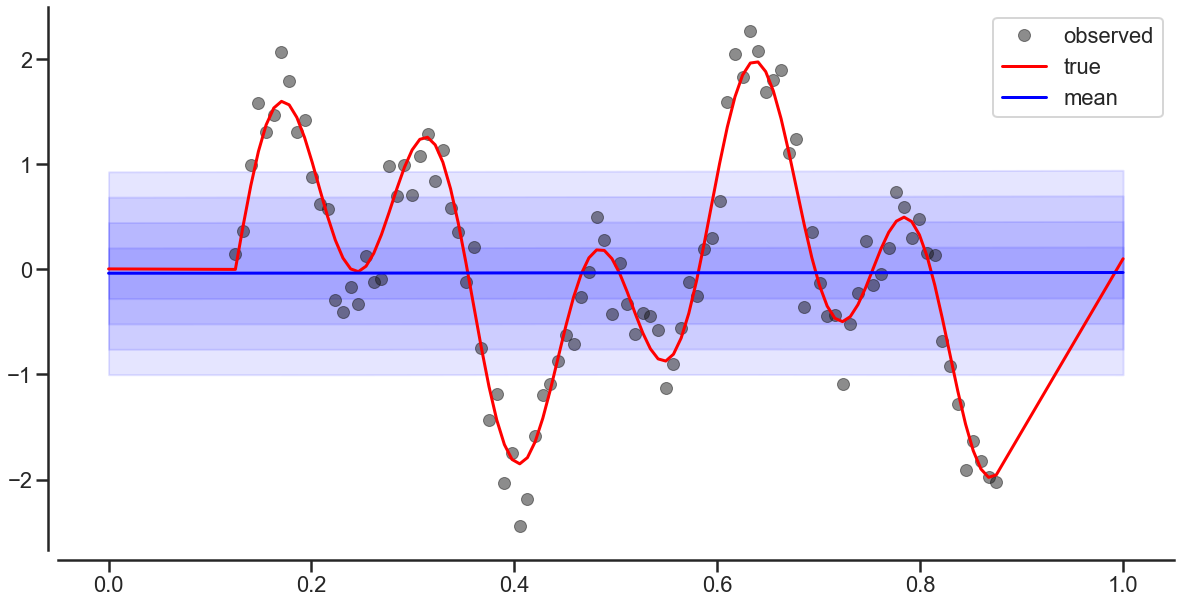

In [17]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = vanilla.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [18]:
for i in trange(epochs):

    vanilla.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:21<00:00, 70.79it/s]


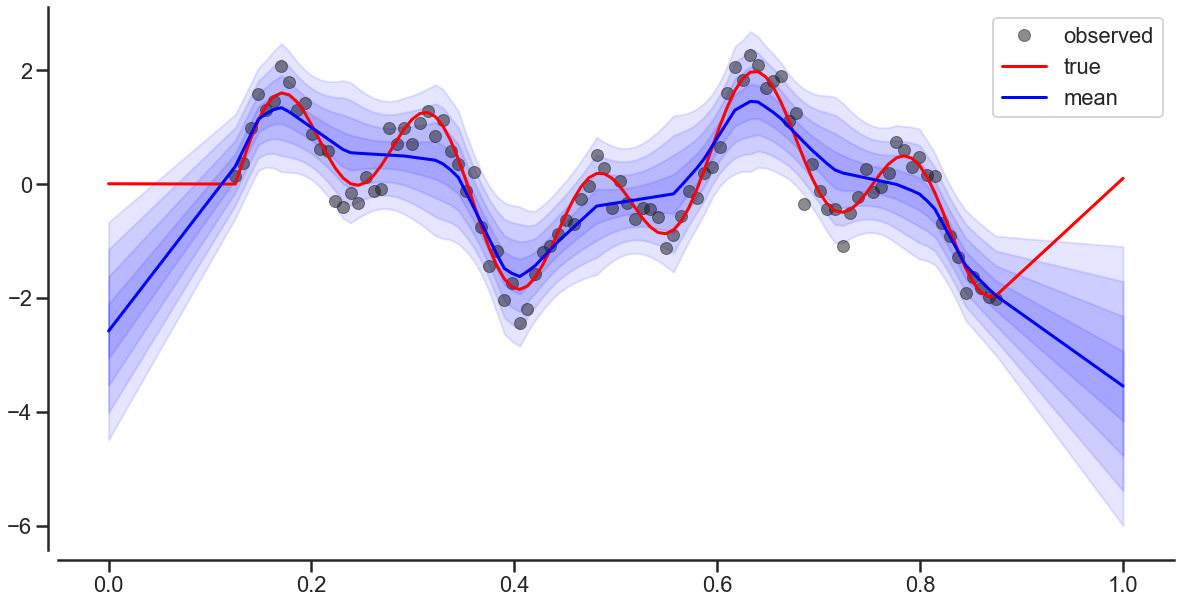

In [20]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = vanilla.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

## Shuffle Ensemble

In [21]:

class ShuffleEnsemble(VanillaEnsemble):


    def fit_model(self, X_abs, y_abs):
        losslist = []
        for model,optimizer in zip(self.models,self.optimizers):
            
            shuffled_X, shuffled_y = self.shuffle(X_abs,y_abs)
            
            losslist.append(self.fit_ensemble_member(model, optimizer, shuffled_X, shuffled_y))
        return losslist
    
    
     

In [22]:
shuffle = ShuffleEnsemble()

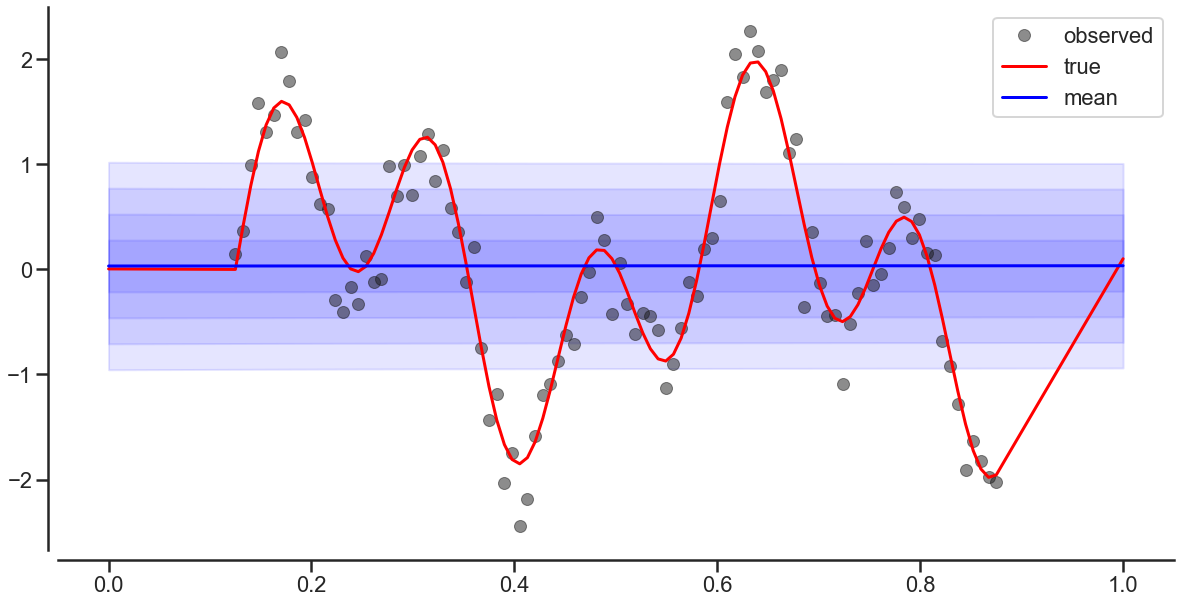

In [23]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = shuffle.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [24]:
for i in trange(epochs):

    shuffle.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:22<00:00, 70.13it/s]


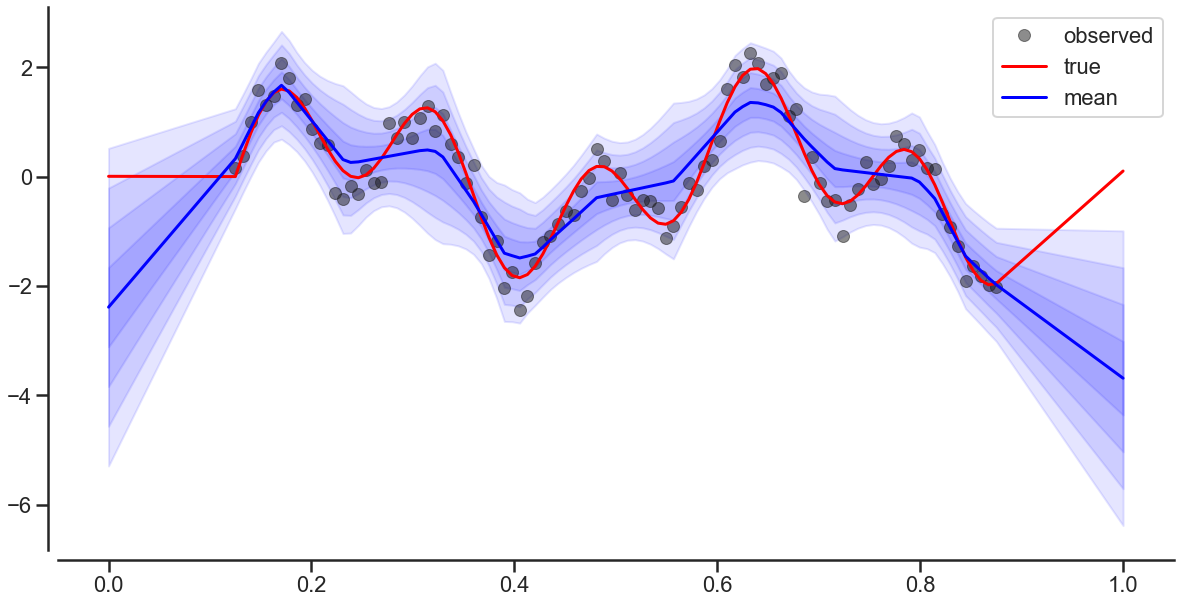

In [25]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = shuffle.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

## Bootstrapensemble

In [26]:
   

class BootstrapEnsemble(VanillaEnsemble):
    def __init__(self,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=4, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None,bootstrap_p_positive=0.7):
        super(BootstrapEnsemble, self).__init__(p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None)
        
        self.dataset_lenght = dataset_lenght
        self.bootstrap_dataset_indices = [np.random.choice(a=[True, False], size=dataset_lenght, p=[bootstrap_p_positive, 1-bootstrap_p_positive]) for model in self.models]


    def fit_model(self, X_abs, y_abs):
        losslist = []
        for model,optimizer,indices in zip(self.models,self.optimizers,self.bootstrap_dataset_indices):
            
            X_bootstrapped, y_bootstrapped = X_abs[indices], y_abs[indices]

            
            shuffled_X, shuffled_y = self.shuffle(X_bootstrapped, y_bootstrapped)
            #shuffled_X, shuffled_y = X_bootstrapped, y_bootstrapped

            
            losslist.append(self.fit_ensemble_member(model, optimizer, shuffled_X, shuffled_y))
        return losslist
    
        

In [27]:
bootstrap = BootstrapEnsemble(dataset_lenght = len(X))

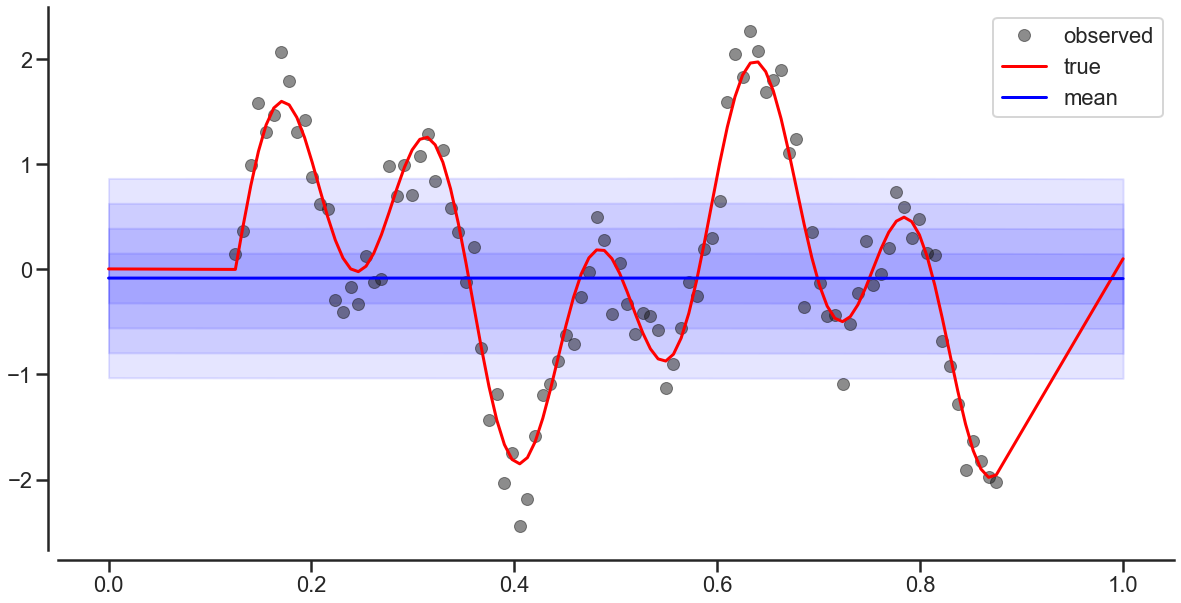

In [28]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = bootstrap.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)

In [29]:
for i in trange(epochs):

    bootstrap.fit_model(X,y)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:28<00:00, 67.20it/s]


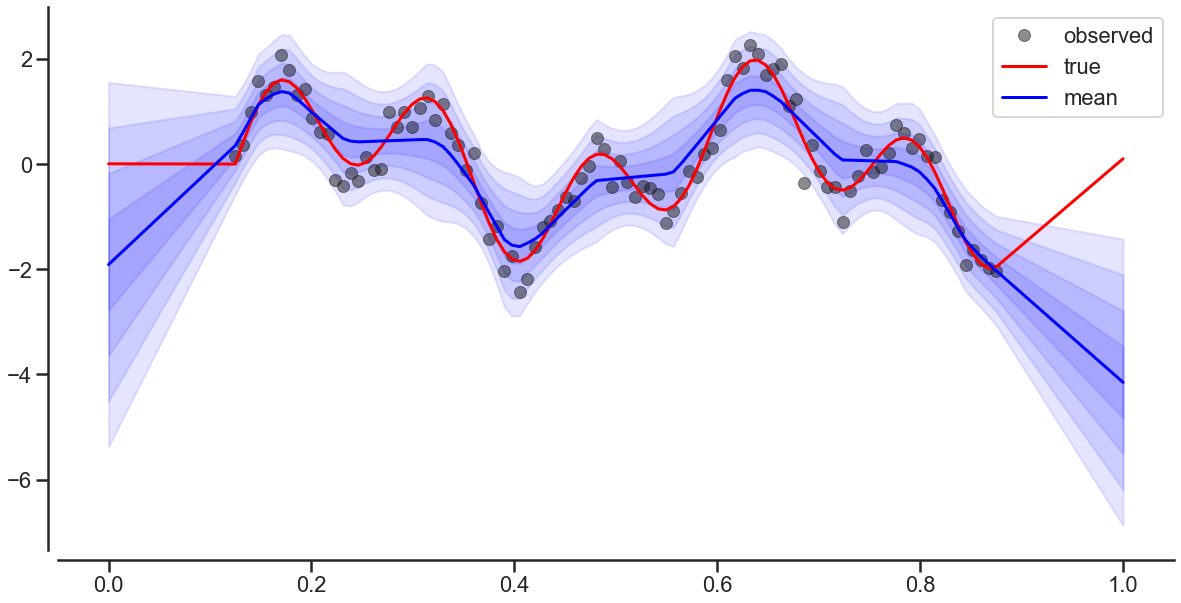

In [30]:
fig, ax = plt.subplots(1,1)
y_mean, y_std = bootstrap.uncertainty_function(X_long, iters, l2=l2)
#y_mean_raw, y_std_raw = vanilla.uncertainty_function(X_long, iters, l2=l2,raw_var=True)


ax.plot(X, y, ls="none", marker="o", color="0.1", alpha=0.5, label="observed")
ax.plot(X_long, y_long, ls="-", color="r", label="true")
ax.plot(X_long, y_mean, ls="-", color="b", label="mean")


    
    
for i in range(n_std):
    ax.fill_between(
        X_long.squeeze(),
        y_mean.squeeze() - y_std.squeeze() * ((i+1)/2),
        y_mean.squeeze() + y_std.squeeze() * ((i+1)/2),
        color="b",
        alpha=0.1
    )
    
ax.legend()
sns.despine(offset=10)